<a href="https://colab.research.google.com/github/KimJisanER/Dacon/blob/main/02_25_image_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')

os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당


In [2]:
import tensorflow as tf

In [3]:
#create training dataset
from glob import glob
import numpy as np
import PIL
from PIL import Image

path = '/content/drive/MyDrive/Image_classi/data/train/'

training_images = []
training_labels = []

for filename in glob(path +"*"):
    for img in glob(filename + "/*.jpg"):
        an_img = PIL.Image.open(img) #read img
        img_array = np.array(an_img) #img to array
        training_images.append(img_array) #append array to training_images 
        label = filename.split('/')[-1] #get label
        training_labels.append(label) #append label
        
training_images = np.array(training_images)
training_labels = np.array(training_labels)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

print(training_images.shape)
print(training_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


In [4]:
print(training_labels)

[[2]
 [2]
 [2]
 ...
 [5]
 [5]
 [5]]


In [5]:
#create test dataset

path = '/content/drive/MyDrive/Image_classi/data/test/'

test_images = []
test_idx = []

flist = sorted(glob(path + '*.jpg'))

for filename in flist:
    an_img = PIL.Image.open(filename) #read img
    img_array = np.array(an_img) #img to array
    test_images.append(img_array) #append array to training_images 
    
    label = filename.split('/')[-1] #get id 
    test_idx.append(label) #append id
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:5])

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


[2],[2],[9],[9],[0],[0],[3],[3],[1],[1],[8],[8],[6],[6],[4],[4],[7],[7],[5],[5],

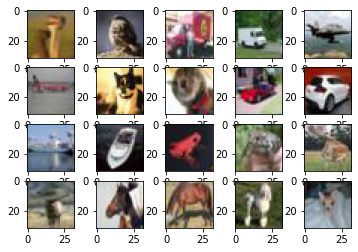

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(training_images[i*2500])
    print(training_labels[i*2500], end=",")
plt.show()

In [7]:
label_num = [0,1,2,3,4,5,6,7,8,9]
label_name = le.inverse_transform(label_num)

for i in range(10):
  print(label_num[i], label_name[i])

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [8]:
from matplotlib import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    
    rotation_range = 20,
    brightness_range = [0.9,1.0],
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)


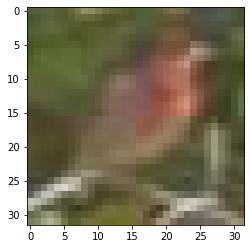

In [9]:
sample_image = training_images[1]
plt.imshow(sample_image.astype('uint8'))
sample_image = np.expand_dims(sample_image,0)

In [10]:
sample_image_it = image_generator.flow(sample_image, batch_size=1)

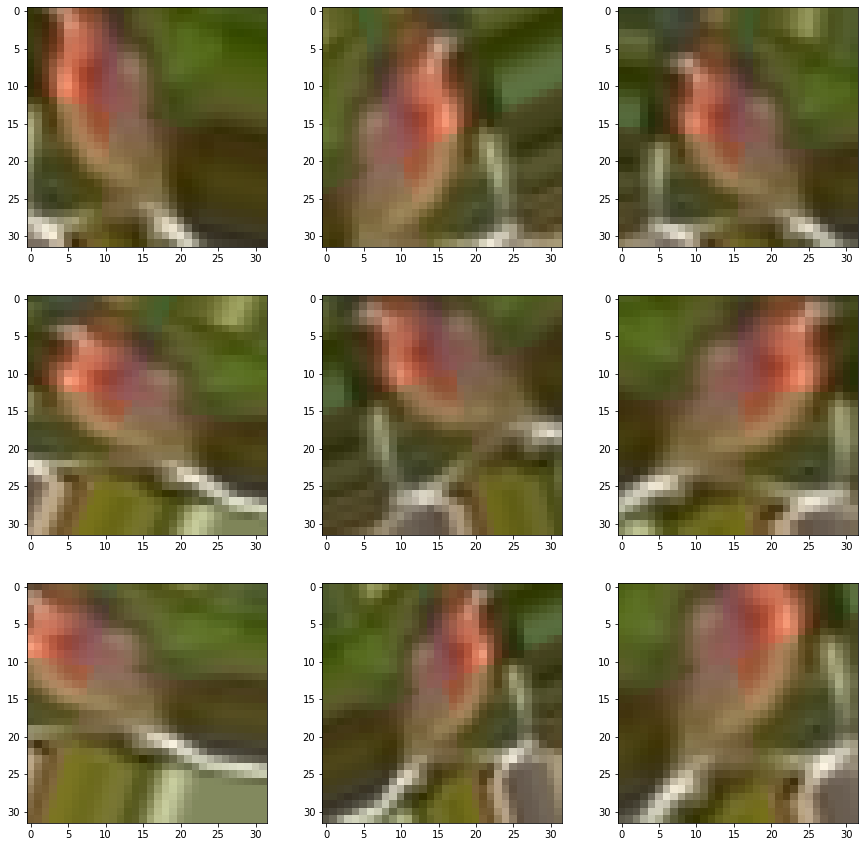

In [11]:
fig = plt.figure(figsize = (15,15))
for i in range(9):
  plt.subplot(3,3,1+i)
  batch = sample_image_it.next()
  image = batch[0].astype('uint8')
  plt.imshow(image)
plt.show()

In [12]:
augment_size = 250000

random_mask = np.random.randint(training_images.shape[0], size=augment_size)
training_image_aug = training_images[random_mask].copy()
training_labels_aug = training_labels[random_mask].copy()

In [13]:
training_image_aug = image_generator.flow(training_image_aug, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

training_images = np.concatenate((training_images, training_image_aug))
training_labels = np.concatenate((training_labels, training_labels_aug))

In [14]:
print(training_images.shape)
print(training_labels.shape)

(300000, 32, 32, 3)
(300000, 1)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(training_images, training_labels, test_size=0.2, stratify = training_labels, random_state=1809)

X_test = test_images

In [16]:
print('X_train 크기:',X_train.shape)
print('X_valid 크기:',X_valid.shape)
print('X_test  크기:',X_test.shape)

X_train 크기: (240000, 32, 32, 3)
X_valid 크기: (60000, 32, 32, 3)
X_test  크기: (10000, 32, 32, 3)


In [17]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

In [18]:
# X_train = tf.image.resize(X_train, [224,224])
# X_valid = tf.image.resize(X_valid, [224,224])
# X_test = tf.image.resize(X_test, [224,224])

In [19]:
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [20]:
model = tf.keras.applications.ResNet50(include_top=True, weights=None, input_shape=(32, 32, 3), pooling=max, classes=10)

In [21]:
model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
save = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
callback = [es, save]

In [24]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=128, callbacks=callback )

Epoch 1/100
1875/1875 [==============================] - 125s 58ms/step - loss: 1.7530 - accuracy: 0.4054 - val_loss: 1.6132 - val_accuracy: 0.4679
Epoch 2/100
1875/1875 [==============================] - 107s 57ms/step - loss: 1.8203 - accuracy: 0.3897 - val_loss: 2.0382 - val_accuracy: 0.4170
Epoch 3/100
1875/1875 [==============================] - 107s 57ms/step - loss: 1.5876 - accuracy: 0.4613 - val_loss: 2.6120 - val_accuracy: 0.2907
Epoch 4/100
1875/1875 [==============================] - 107s 57ms/step - loss: 1.9223 - accuracy: 0.3479 - val_loss: 7.4633 - val_accuracy: 0.2605
Epoch 5/100
1875/1875 [==============================] - 107s 57ms/step - loss: 1.8222 - accuracy: 0.3706 - val_loss: 2.7839 - val_accuracy: 0.2718
Epoch 6/100
1875/1875 [==============================] - 107s 57ms/step - loss: 1.8511 - accuracy: 0.3550 - val_loss: 2.0068 - val_accuracy: 0.3240
Epoch 7/100
1875/1875 [==============================] - 107s 57ms/step - loss: 1.6367 - accuracy: 0.4249 - val_

In [25]:
pred_proba = model.predict(X_test) 

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)
    
pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array(['horse', 'airplane', 'airplane', 'truck', 'bird'], dtype='<U10')

In [26]:
import pandas as pd

sample_submission = pd.read_csv("/content/drive/MyDrive/Image_classi/data/sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("/content/drive/MyDrive/Image_classi/data/22_02_25_submit_1.csv",index=False)